In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn import manifold
%matplotlib inline

import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

pd.set_option('display.max_columns', None)

In [2]:
prev_lives_train = pd.read_csv('../data/previous_lives_training_data.csv', index_col=0)
prev_lives_test = pd.read_csv('../data/previous_lives_test_data.csv', index_col=0)

registration_train = pd.read_csv('../data/registration_data_training.csv', index_col=0)
registration_test = pd.read_csv('../data/registration_data_test.csv', index_col=0)

prev_lives_train.shape, prev_lives_test.shape, registration_train.shape, registration_test.shape

((84941, 10), (86113, 10), (50000, 29), (50000, 28))

In [3]:
registration_train.head(3)

,registration_time_utc,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,tokens_spent,tokens_stash,tokens_bought,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2024-05-25 01:26:48.000,iOS Phone,France,AppStore,7,Organic,Phone,Apple,1,141062,1,2,1,0,0,0,0,114,0,524,0,0,0,1066076772,4.721867,5.451511,22.0,0,0
7,2024-06-14 20:09:31.000,Android Phone,Turkey,GooglePlay,27,Unknown,Phone,Xiaomi,1,521754,1,0,0,0,0,0,0,157,0,962,0,0,0,1224446429,4.911067,5.303822,22.0,1,0
13,2024-05-31 09:06:51.000,Android Phone,Belarus,GooglePlay,13,Organic,Phone,Xiaomi,2,1703183,1,0,0,0,0,0,20,232,0,829,0,0,0,1221792142,5.018146,5.746889,24.0,3,0


In [4]:
prev_lives_train.head(3)

,registration_date,registration_season_day,registration_country,registration_channel_detailed,registration_store,registration_platform_specific,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
user_id,,,,,,,,,,
5,2022-04-21,26,France,Organic,AppStore,iOS Phone,False,1,0,False
5,2023-05-07,15,France,Paid,AppStore,iOS Phone,False,18,0,True
7,2022-04-06,11,Turkey,Organic,AppStore,iOS Phone,False,21,0,True


In [5]:
np.intersect1d(registration_train.columns, prev_lives_train.columns)

array(['registration_channel_detailed', 'registration_country',
       'registration_platform_specific', 'registration_season_day',
       'registration_store'], dtype=object)

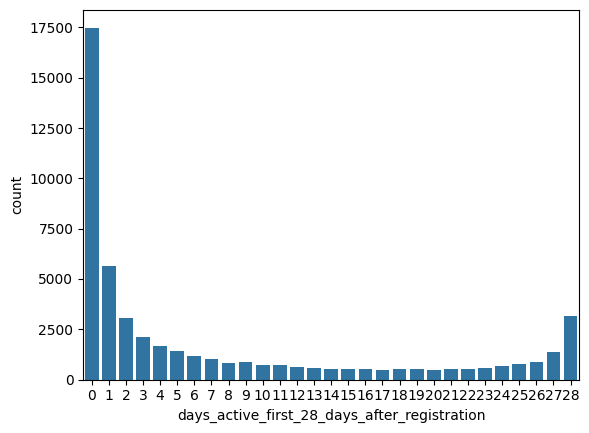

In [6]:
# target variable distribution
sns.countplot(x='days_active_first_28_days_after_registration', data=registration_train)
plt.show()

# skewed and zero-inflated; many users with 28 days active might indicate sepcific behavior of users

In [7]:
registration_train.value_counts('days_active_first_28_days_after_registration', normalize=True).sort_values(ascending=False)[:10]

days_active_first_28_days_after_registration
0     0.34982
1     0.11284
28    0.06368
2     0.06090
3     0.04276
4     0.03296
5     0.02806
27    0.02740
6     0.02330
7     0.02034
Name: proportion, dtype: float64

### Data Cleaning and Preprocessing

In [8]:
import sys
import os
current_dir = os.getcwd() 
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(project_root)

from src.check_values_train_test import check_values
from config import nominal_features_registration, nominal_features_prev_lives


print("======= Registration data:")
check_values(['../data/registration_data_training.csv', '../data/registration_data_test.csv'], nominal_features_registration)
print("\n======= Previous lives data:")
check_values(['../data/previous_lives_training_data.csv', '../data/previous_lives_test_data.csv'], nominal_features_prev_lives)
print("\n======= Intersection of registration and previous lives data:")
check_values(['../data/registration_data_training.csv', '../data/registration_data_test.csv', '../data/previous_lives_training_data.csv', '../data/previous_lives_test_data.csv'], np.intersect1d(nominal_features_registration, nominal_features_prev_lives))

======= Registration data:

Checking feature: registration_platform_specific
✓ Values match
Unique values: ['Android Phone', 'Android Tablet', 'UniversalWindows PC', 'WebGL FB Canvas', 'WebGL TE Site', 'iOS Phone', 'iOS Tablet']

Checking feature: registration_country
❌ Values mismatch detected!
Values missing in dataset 0 (../data/registration_data_training.csv): {'Madagascar', 'Monaco', 'Cook Islands', 'Bermuda', 'Dominica', 'Saint Martin', 'Curacao', 'San Marino', 'Virgin Islands, British', 'Burundi', 'Timor-Leste', 'Antigua and Barbuda', 'Lesotho', 'Bahamas', 'Seychelles'}
Values missing in dataset 1 (../data/registration_data_test.csv): {'Cayman Islands', 'New Caledonia', 'Unknown', 'Fiji', 'Guinea-Bissau', 'Isle of Man', 'Mayotte', 'Saint Lucia', 'Comoros', 'Djibouti', 'Sierra Leone', 'French Polynesia'}

Checking feature: registration_store
✓ Values match
Unique values: ['AppStore', 'Catappult', 'Facebook', 'GooglePlay', 'GooglePlayForPC', 'Huawei', 'WindowsStore']

Checking fea

Comment: we can see that the registration_country has a lot of mismatched values across different datasets. For this reason, we can examine the distribution of country values and replace all countries that are rare in the datasets with the value "Other"
This will be added in the data_cleaning.py script

In [9]:
df_concatenated_country = pd.concat([
    df.filter(['registration_country']) 
    for df in [registration_train, registration_test, prev_lives_train, prev_lives_test]
])
df_concatenated_country.value_counts(normalize=True)[:15]


registration_country
Indonesia               0.225402
Turkey                  0.087787
Brazil                  0.064260
Germany                 0.043036
France                  0.034307
United Kingdom          0.033351
Thailand                0.029171
Spain                   0.028452
Poland                  0.027375
Italy                   0.026851
Malaysia                0.021664
United States           0.018207
Argentina               0.017284
Romania                 0.016554
Greece                  0.016119
Name: proportion, dtype: float64

Comment: As assumed, we can see that the country values are distributed very unevenly, with only a few countries having a significant number of users. We can replace all countries that are rare in the datasets with the value "Other". Strangely, the country "United States" is not in the top 10 most frequent countries. Also, Indonesia is the most frequent country, which is interesting.

In [10]:
df_concatenated_country.value_counts().describe()

count      206.000000
mean      1315.796117
std       4960.620127
min          1.000000
25%         16.000000
50%        132.000000
75%        703.500000
max      61096.000000
Name: count, dtype: float64

In [11]:
df_concatenated_country.value_counts(normalize=True).values[:50].sum()

np.float64(0.9194256495015753)

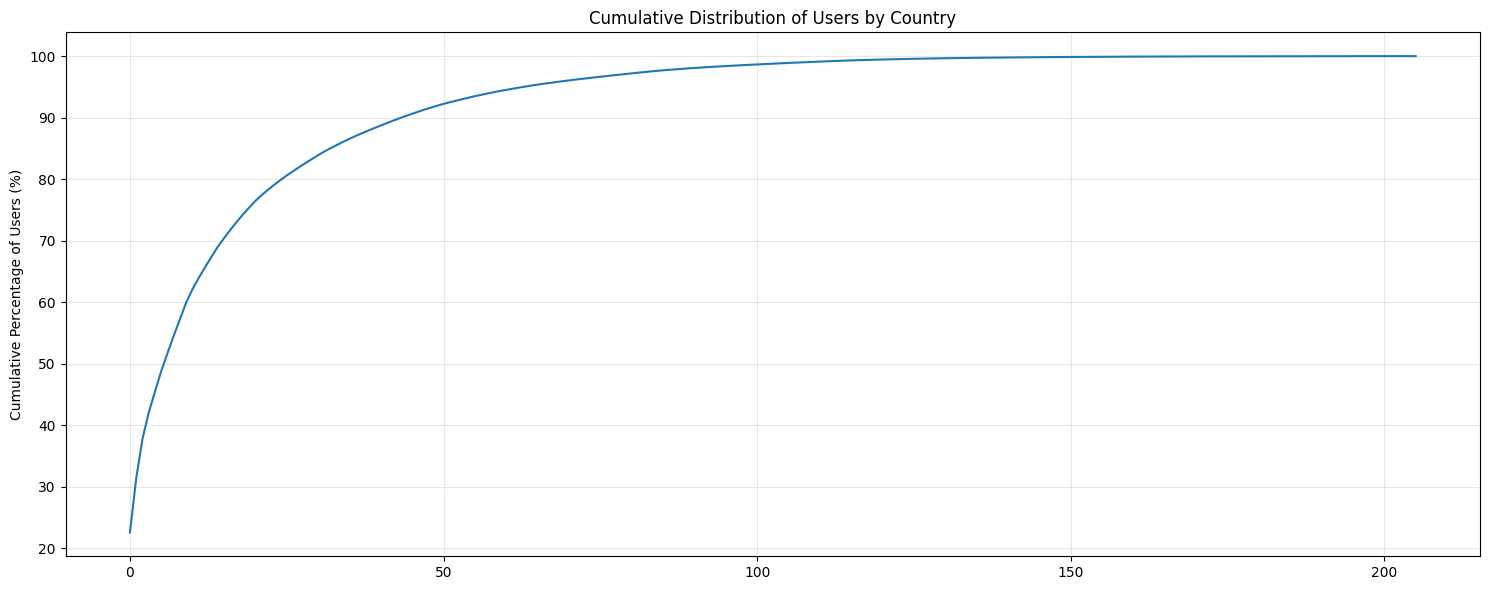

In [12]:
value_counts = df_concatenated_country.value_counts(normalize=True)

cumulative_counts = (value_counts.cumsum() * 100)

# plot
plt.figure(figsize=(15, 6))
sns.lineplot(x=range(len(cumulative_counts)), y=cumulative_counts.values)
  
plt.ylabel('Cumulative Percentage of Users (%)')
plt.title('Cumulative Distribution of Users by Country')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
percentage_threshold = 95
threshold = value_counts[cumulative_counts <= percentage_threshold].values[-1]
filtered_countries = value_counts[value_counts > threshold]
cumulative_counts_filtered = cumulative_counts[cumulative_counts <= percentage_threshold]
print(f'{threshold=}')
print(f'Number of countries that exceed the threshold: {len(cumulative_counts_filtered)}')
print(f'{cumulative_counts_filtered.iloc[-1]:.2f}% of users covered by first {len(cumulative_counts_filtered)} countries', )

threshold=np.float64(0.0017745541478819719)
Number of countries that exceed the threshold: 63
94.88% of users covered by first 63 countries


We will save this threshold in the config.py file as country_threshold, so all countries with a frequency lower than this threshold will be replaced with "Other".

In [113]:
# checking if the data cleaning script works (after running it using the src/data_cleaning.py script)
cleaned_registration_train = pd.read_csv('../cleaned_data/registration_data_training.csv', index_col=0)
cleaned_registration_train.registration_country.value_counts()

registration_country
Indonesia     12018
Turkey         4472
Brazil         3067
Other          2723
Germany        2130
              ...  
Ireland          97
Uruguay          95
Kazakhstan       95
Albania          92
Finland          78
Name: count, Length: 63, dtype: int64

Comment: We can see that the "Other" category now has a much higher frequency. This is not surprising, as we replaced all countries with a frequency lower than the threshold with "Other". However, we can see that it is now the 4th most frequent country, which is not ideal because it is not very informative. We can try to improve this by using continent as additional information. This will be done later.

We can repeat the same process for registration_device_manufacturer column

In [247]:
df_registration_device_manufacturer = pd.concat([
    df.filter(['registration_device_manufacturer']) 
    for df in [registration_train, registration_test, prev_lives_train, prev_lives_test]
])
df_registration_device_manufacturer.value_counts(normalize=True)[:15]

registration_device_manufacturer
Apple                               0.254641
samsung                             0.253999
Xiaomi                              0.196668
OPPO                                0.062635
vivo                                0.044661
realme                              0.040175
motorola                            0.031172
HUAWEI                              0.023361
INFINIX                             0.017239
INFINIX MOBILITY LIMITED            0.011572
HONOR                               0.009873
TECNO                               0.007500
Google                              0.006382
OnePlus                             0.005377
LENOVO                              0.003491
Name: proportion, dtype: float64

In [248]:
df_registration_device_manufacturer.describe()

,registration_device_manufacturer
count,96528
unique,242
top,Apple
freq,24580


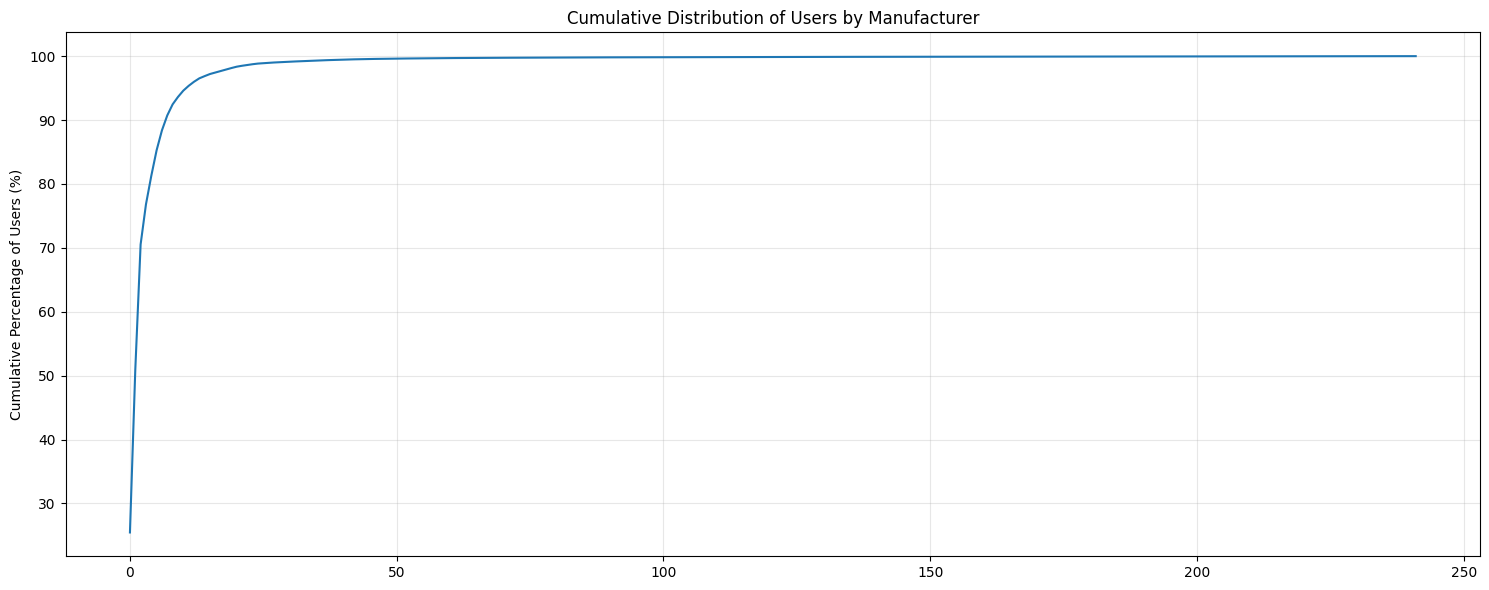

In [251]:
value_counts = df_registration_device_manufacturer.value_counts(normalize=True)

cumulative_counts = (value_counts.cumsum() * 100)

# plot
plt.figure(figsize=(15, 6))
sns.lineplot(x=range(len(cumulative_counts)), y=cumulative_counts.values)
  
plt.ylabel('Cumulative Percentage of Users (%)')
plt.title('Cumulative Distribution of Users by Manufacturer')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Comment: Here, the situation is even more skewed than with the country column. We can see that the manufacturers are distributed very unevenly, with only a few manufacturers having a significant number of users. We can map all manufacturers with a frequency lower than the threshold (say 1%) with "Other". We can also add this to the config.py file as manufacturer_threshold.

In [249]:
df_registration_device_manufacturer.value_counts(normalize=True)[:15]

registration_device_manufacturer
Apple                               0.254641
samsung                             0.253999
Xiaomi                              0.196668
OPPO                                0.062635
vivo                                0.044661
realme                              0.040175
motorola                            0.031172
HUAWEI                              0.023361
INFINIX                             0.017239
INFINIX MOBILITY LIMITED            0.011572
HONOR                               0.009873
TECNO                               0.007500
Google                              0.006382
OnePlus                             0.005377
LENOVO                              0.003491
Name: proportion, dtype: float64

Comment: We can see that we should map "INFINIX" and "INFINIX MOBILITY LIMITED" to "INFINIX".
Below that, all manufacturers have a very low number of users (less than 1%), so we can map all of them to "Other".
We can also add this to the config.py file as manufacturer_threshold.

In [208]:
# checking if the data cleaning script works (after running it using the src/data_cleaning.py script)
cleaned_registration_train = pd.read_csv('../cleaned_data/registration_data_training.csv', index_col=0)
cleaned_registration_train.registration_device_manufacturer.value_counts(normalize=True)

registration_device_manufacturer
Apple       0.24136
samsung     0.23630
Xiaomi      0.19370
Other       0.10918
OPPO        0.06238
vivo        0.04596
realme      0.04144
motorola    0.02928
HUAWEI      0.02278
INFINIX     0.01762
Name: proportion, dtype: float64

In [210]:
# check values after cleaning

print("======= Registration data:")
check_values(['../cleaned_data/registration_data_training.csv', '../cleaned_data/registration_data_test.csv'], nominal_features_registration)
print("\n======= Previous lives data:")
check_values(['../cleaned_data/previous_lives_training_data.csv', '../cleaned_data/previous_lives_test_data.csv'], nominal_features_prev_lives)


======= Registration data:

Checking feature: registration_platform_specific
✓ Values match
Unique values: ['Android Phone', 'Android Tablet', 'UniversalWindows PC', 'WebGL FB Canvas', 'WebGL TE Site', 'iOS Phone', 'iOS Tablet']

Checking feature: registration_country
✓ Values match
Unique values: ['Algeria', 'Argentina', 'Australia', 'Austria', 'Azerbaijan', 'Belgium', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Croatia', 'Czech Republic', 'Denmark', 'Egypt', 'France', 'Germany', 'Greece', 'India', 'Indonesia', 'Israel', 'Italy', 'Malaysia', 'Mexico', 'Morocco', 'Netherlands', 'Nigeria', 'Other', 'Peru', 'Poland', 'Portugal', 'Romania', 'Saudi Arabia', 'Serbia', 'Slovakia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'Turkey', 'Ukraine', 'United Kingdom', 'United States', 'Vietnam']

Checking feature: registration_store
✓ Values match
Unique values: ['AppStore', 'Catappult', 'Facebook', 'GooglePlay', 'GooglePlayForPC', 'Huawei', 'WindowsStore']

Checking feature: regis

### Label encoding

Let's check the label encoded data as a result of running the src/label_encoding.py script.

In [198]:
prev_lives_train_labeled = pd.read_csv('../cleaned_data/previous_lives_training_data_labeled.csv', index_col=0)
prev_lives_test_labeled = pd.read_csv('../cleaned_data/previous_lives_test_data_labeled.csv', index_col=0)

registration_train_labeled = pd.read_csv('../cleaned_data/registration_data_training_labeled.csv', index_col=0)
registration_test_labeled = pd.read_csv('../cleaned_data/registration_data_test_labeled.csv', index_col=0)

In [199]:
prev_lives_train_labeled.head()

,registration_date,registration_season_day,registration_country,registration_channel_detailed,registration_store,registration_platform_specific,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
user_id,,,,,,,,,,
5,2022-04-21,26,19,0,0,5,0,1,0,0
5,2023-05-07,15,19,1,0,5,0,18,0,1
7,2022-04-06,11,55,0,0,5,0,21,0,1
7,2023-02-06,9,55,0,3,0,0,2,0,0
7,2023-05-28,8,55,2,3,0,0,1,0,0


In [193]:
prev_lives_train.head()

,registration_date,registration_season_day,registration_country,registration_channel_detailed,registration_store,registration_platform_specific,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime,year,week,month,dayofweek,weekend
user_id,,,,,,,,,,,,,,,
5,2022-04-21,26,France,Organic,AppStore,iOS Phone,False,1,0,False,2022,16,4,3,0
5,2023-05-07,15,France,Paid,AppStore,iOS Phone,False,18,0,True,2023,18,5,6,1
7,2022-04-06,11,Turkey,Organic,AppStore,iOS Phone,False,21,0,True,2022,14,4,2,0
7,2023-02-06,9,Turkey,Organic,GooglePlay,Android Phone,False,2,0,False,2023,6,2,0,0
7,2023-05-28,8,Turkey,Unknown,GooglePlay,Android Phone,False,1,0,False,2023,21,5,6,1


In [194]:
registration_train_labeled.head()

,registration_time_utc,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,tokens_spent,tokens_stash,tokens_bought,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2024-05-25 01:26:48.000,5,19,0,7,0,1,0,1,141062,1,2,1,0,0,0,0,114,0,524,0,0,0,1066076772,4.721867,5.451511,22.0,0,0
7,2024-06-14 20:09:31.000,0,55,3,27,2,1,5,1,521754,1,0,0,0,0,0,0,157,0,962,0,0,0,1224446429,4.911067,5.303822,22.0,1,0
13,2024-05-31 09:06:51.000,0,39,3,13,0,1,5,2,1703183,1,0,0,0,0,0,20,232,0,829,0,0,0,1221792142,5.018146,5.746889,24.0,3,0
23,2024-05-31 04:00:33.000,0,24,3,13,1,1,3,4,3181700,1,3,2,1,0,0,79,8,0,180,39,12,9,928112709,5.827455,6.692578,22.0,7,1
25,2024-06-15 19:56:05.000,5,17,0,28,0,1,0,5,5866921,1,1,0,1,0,0,77,70,0,209,80,0,2,326553498,5.340412,5.775289,24.0,6,3


In [142]:
registration_train.head()

,registration_time_utc,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,tokens_spent,tokens_stash,tokens_bought,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2024-05-25 01:26:48.000,iOS Phone,France,AppStore,7,Organic,Phone,Apple,1,141062,1,2,1,0,0,0,0,114,0,524,0,0,0,1066076772,4.721867,5.451511,22.0,0,0
7,2024-06-14 20:09:31.000,Android Phone,Turkey,GooglePlay,27,Unknown,Phone,Xiaomi,1,521754,1,0,0,0,0,0,0,157,0,962,0,0,0,1224446429,4.911067,5.303822,22.0,1,0
13,2024-05-31 09:06:51.000,Android Phone,Belarus,GooglePlay,13,Organic,Phone,Xiaomi,2,1703183,1,0,0,0,0,0,20,232,0,829,0,0,0,1221792142,5.018146,5.746889,24.0,3,0
23,2024-05-31 04:00:33.000,Android Phone,Indonesia,GooglePlay,13,Paid,Phone,OPPO,4,3181700,1,3,2,1,0,0,79,8,0,180,39,12,9,928112709,5.827455,6.692578,22.0,7,1
25,2024-06-15 19:56:05.000,iOS Phone,Egypt,AppStore,28,Organic,Phone,Apple,5,5866921,1,1,0,1,0,0,77,70,0,209,80,0,2,326553498,5.340412,5.775289,24.0,6,3


In [144]:
# check values after label encoding

print("======= Registration data:")
check_values(['../cleaned_data/registration_data_training_labeled.csv', '../cleaned_data/registration_data_test_labeled.csv'], nominal_features_registration)
print("\n======= Previous lives data:")
check_values(['../cleaned_data/previous_lives_training_data_labeled.csv', '../cleaned_data/previous_lives_test_data_labeled.csv'], nominal_features_prev_lives)
print("\n======= Intersection of registration and previous lives data:")
check_values(['../cleaned_data/registration_data_training_labeled.csv', '../cleaned_data/registration_data_test_labeled.csv', '../cleaned_data/previous_lives_training_data_labeled.csv', '../cleaned_data/previous_lives_test_data_labeled.csv'], np.intersect1d(nominal_features_registration, nominal_features_prev_lives))


======= Registration data:

Checking feature: registration_platform_specific
✓ Values match
Unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Checking feature: registration_country
✓ Values match
Unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52)

Comment: The encoded data looks good. We can see that for the registration_store, we have a single value that can only be found in past lives data. We will ignore this for now.

### Previous lives data

Now let's check the previous lives data. We want to merge it with the registration data, but first we need to do some feature engineering in order use the information from all columns in the previous lives data.

In [124]:
prev_lives_train.head()

,registration_date,registration_season_day,registration_country,registration_channel_detailed,registration_store,registration_platform_specific,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
user_id,,,,,,,,,,
5,2022-04-21,26,France,Organic,AppStore,iOS Phone,False,1,0,False
5,2023-05-07,15,France,Paid,AppStore,iOS Phone,False,18,0,True
7,2022-04-06,11,Turkey,Organic,AppStore,iOS Phone,False,21,0,True
7,2023-02-06,9,Turkey,Organic,GooglePlay,Android Phone,False,2,0,False
7,2023-05-28,8,Turkey,Unknown,GooglePlay,Android Phone,False,1,0,False


In [100]:
most_common_user_id = prev_lives_train.index.value_counts().index[0]
prev_lives_train[prev_lives_train.index == most_common_user_id].sort_values(by='registration_date')

,registration_date,registration_season_day,registration_country,registration_channel_detailed,registration_store,registration_platform_specific,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
user_id,,,,,,,,,,
201487,2022-04-02,7,Poland,Organic,GooglePlay,Android Phone,False,1,0,False
201487,2022-09-05,23,Poland,Paid,GooglePlay,Android Phone,False,4,0,False
201487,2022-11-11,6,Poland,Paid,GooglePlay,Android Phone,True,38,11,True
201487,2023-04-22,28,Poland,Organic,GooglePlay,Android Phone,False,1,0,False
201487,2023-06-22,5,Poland,Unknown,GooglePlay,Android Phone,False,1,0,False
201487,2023-09-22,13,Poland,Organic,GooglePlay,Android Phone,False,1,0,False
201487,2023-12-31,1,Poland,Organic,GooglePlay,Android Phone,False,2,0,False


In [ ]:
## feature engineering
## we can transfrom the registration_date column in various ways
## we can combine different columns in various ways
## we can count different types of events in the previous lives data:
## 1. number of unique registrations
## 2. number of total days active, mean days active, max days active min days active, median days active, std days active
## 3. number of unique regstration country/channel/store/platform
## 4. number of total in-app purchases / is_player_lifetime / is_rewarded_video_watcher_lifetime

In [200]:
# transforming the registration_date column
prev_lives_train_labeled.loc[:, 'year'] = prev_lives_train_labeled['registration_date'].astype('datetime64[ns]').dt.year
prev_lives_train_labeled.loc[:, 'week'] = prev_lives_train_labeled['registration_date'].astype('datetime64[ns]').dt.isocalendar().week
prev_lives_train_labeled.loc[:, 'month'] = prev_lives_train_labeled['registration_date'].astype('datetime64[ns]').dt.month
prev_lives_train_labeled.loc[:, 'dayofweek'] = prev_lives_train_labeled['registration_date'].astype('datetime64[ns]').dt.dayofweek
prev_lives_train_labeled.loc[:, 'dayofmonth'] = prev_lives_train_labeled['registration_date'].astype('datetime64[ns]').dt.day
prev_lives_train_labeled.loc[:, 'weekend'] = (prev_lives_train_labeled['registration_date'].astype('datetime64[ns]').dt.dayofweek >= 5).astype(int)
prev_lives_train_labeled.head()

,registration_date,registration_season_day,registration_country,registration_channel_detailed,registration_store,registration_platform_specific,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime,year,week,month,dayofweek,dayofmonth,weekend
user_id,,,,,,,,,,,,,,,,
5,2022-04-21,26,19,0,0,5,0,1,0,0,2022,16,4,3,21,0
5,2023-05-07,15,19,1,0,5,0,18,0,1,2023,18,5,6,7,1
7,2022-04-06,11,55,0,0,5,0,21,0,1,2022,14,4,2,6,0
7,2023-02-06,9,55,0,3,0,0,2,0,0,2023,6,2,0,6,0
7,2023-05-28,8,55,2,3,0,0,1,0,0,2023,21,5,6,28,1


In [196]:
# create an aggregate dictionary
aggs = {}
# number of unique and also the most common one
aggs['year'] = ['nunique', lambda x: x.mode().iloc[0] if not x.mode().empty else None]
aggs['month'] = ['nunique', lambda x: x.mode().iloc[0] if not x.mode().empty else None]
aggs['week'] = ['nunique', lambda x: x.mode().iloc[0] if not x.mode().empty else None]
aggs['dayofweek'] = ['nunique', lambda x: x.mode().iloc[0] if not x.mode().empty else None]
aggs['dayofmonth'] = ['nunique', lambda x: x.mode().iloc[0] if not x.mode().empty else None]
aggs['weekend'] = ['nunique', lambda x: x.mode().iloc[0] if not x.mode().empty else None]

aggs['registration_country'] = ['nunique']
aggs['registration_channel_detailed'] = ['nunique']
aggs['registration_store'] = ['nunique']
aggs['registration_platform_specific'] = ['nunique']

aggs['is_payer_lifetime'] = ['sum']
aggs['is_rewarded_video_watcher_lifetime'] = ['sum']
aggs['days_active_lifetime'] = ['sum', 'mean', 'max', 'min']
aggs['transaction_count_iap_lifetime'] = ['sum', 'mean', 'max', 'min']


# we group by user_id (index) and calculate the aggregates
agg_df = prev_lives_train_labeled.groupby(level=0).agg(aggs)
agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] != '<lambda_0>' else f"{col[0]}_mode" 
                  for col in agg_df.columns]
agg_df = agg_df.reset_index()
agg_df.set_index('user_id', inplace=True)
agg_df.head()

,year_nunique,year_mode,month_nunique,month_mode,week_nunique,week_mode,dayofweek_nunique,dayofweek_mode,dayofmonth_nunique,dayofmonth_mode,weekend_nunique,weekend_mode,registration_country_nunique,registration_channel_detailed_nunique,registration_store_nunique,registration_platform_specific_nunique,is_payer_lifetime_sum,is_rewarded_video_watcher_lifetime_sum,days_active_lifetime_sum,days_active_lifetime_mean,days_active_lifetime_max,days_active_lifetime_min,transaction_count_iap_lifetime_sum,transaction_count_iap_lifetime_mean,transaction_count_iap_lifetime_max,transaction_count_iap_lifetime_min
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2,2022,2,4,2,16,2,3,2,7,2,0,1,2,1,1,0,1,19,9.5,18,1,0,0.0,0,0
7,2,2023,3,2,3,6,3,0,2,6,2,0,1,2,2,2,0,1,24,8.0,21,1,0,0.0,0,0
13,2,2022,2,8,2,33,2,1,2,17,1,0,1,1,1,1,0,1,222,111.0,221,1,0,0.0,0,0
23,1,2023,1,8,1,35,1,2,1,30,1,0,1,1,1,1,0,1,2,2.0,2,2,0,0.0,0,0
25,2,2022,1,8,2,33,2,1,2,15,1,0,1,2,1,1,0,1,19,9.5,18,1,0,0.0,0,0


In [197]:
agg_df[agg_df.index == most_common_user_id].head()

,year_nunique,year_mode,month_nunique,month_mode,week_nunique,week_mode,dayofweek_nunique,dayofweek_mode,dayofmonth_nunique,dayofmonth_mode,weekend_nunique,weekend_mode,registration_country_nunique,registration_channel_detailed_nunique,registration_store_nunique,registration_platform_specific_nunique,is_payer_lifetime_sum,is_rewarded_video_watcher_lifetime_sum,days_active_lifetime_sum,days_active_lifetime_mean,days_active_lifetime_max,days_active_lifetime_min,transaction_count_iap_lifetime_sum,transaction_count_iap_lifetime_mean,transaction_count_iap_lifetime_max,transaction_count_iap_lifetime_min
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,
201487,2,2023,5,4,7,13,5,4,5,22,2,0,1,3,1,1,1,1,48,6.857143,38,1,11,1.571429,11,0


In [168]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 5 to 218956
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   year_nunique                            50000 non-null  int64  
 1   year_mode                               50000 non-null  int32  
 2   month_nunique                           50000 non-null  int64  
 3   month_mode                              50000 non-null  int32  
 4   week_nunique                            50000 non-null  int64  
 5   week_mode                               50000 non-null  UInt32 
 6   dayofweek_nunique                       50000 non-null  int64  
 7   dayofweek_mode                          50000 non-null  int32  
 8   weekend_nunique                         50000 non-null  int64  
 9   weekend_mode                            50000 non-null  int64  
 10  registration_country_nunique            50000 non-null  int64 

#### Registration data, date column transformation

In [180]:
registration_train_labeled.head(3)

,registration_time_utc,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,tokens_spent,tokens_stash,tokens_bought,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration,year,week,month,dayofweek,weekend,dayofmonth
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2024-05-25 01:26:48.000,5,19,0,7,0,1,0,1,141062,1,2,1,0,0,0,0,114,0,524,0,0,0,1066076772,4.721867,5.451511,22.0,0,0,2024,21,5,5,1,25
7,2024-06-14 20:09:31.000,0,55,3,27,2,1,5,1,521754,1,0,0,0,0,0,0,157,0,962,0,0,0,1224446429,4.911067,5.303822,22.0,1,0,2024,24,6,4,0,14
13,2024-05-31 09:06:51.000,0,39,3,13,0,1,5,2,1703183,1,0,0,0,0,0,20,232,0,829,0,0,0,1221792142,5.018146,5.746889,24.0,3,0,2024,22,5,4,0,31


In [182]:
registration_train_labeled.loc[:, 'year'] = registration_train_labeled['registration_time_utc'].astype('datetime64[ns]').dt.year
registration_train_labeled.loc[:, 'week'] = registration_train_labeled['registration_time_utc'].astype('datetime64[ns]').dt.isocalendar().week
registration_train_labeled.loc[:, 'month'] = registration_train_labeled['registration_time_utc'].astype('datetime64[ns]').dt.month
registration_train_labeled.loc[:, 'dayofweek'] = registration_train_labeled['registration_time_utc'].astype('datetime64[ns]').dt.dayofweek
registration_train_labeled.loc[:, 'dayofmonth'] = registration_train_labeled['registration_time_utc'].astype('datetime64[ns]').dt.day
registration_train_labeled.loc[:, 'weekend'] = (registration_train_labeled['registration_time_utc'].astype('datetime64[ns]').dt.dayofweek >= 5).astype(int)
registration_train_labeled.drop(columns=['registration_time_utc'], inplace=True)
registration_train_labeled.head()

,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,tokens_spent,tokens_stash,tokens_bought,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration,year,week,month,dayofweek,weekend,dayofmonth
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,5,19,0,7,0,1,0,1,141062,1,2,1,0,0,0,0,114,0,524,0,0,0,1066076772,4.721867,5.451511,22.0,0,0,2024,21,5,5,1,25
7,0,55,3,27,2,1,5,1,521754,1,0,0,0,0,0,0,157,0,962,0,0,0,1224446429,4.911067,5.303822,22.0,1,0,2024,24,6,4,0,14
13,0,39,3,13,0,1,5,2,1703183,1,0,0,0,0,0,20,232,0,829,0,0,0,1221792142,5.018146,5.746889,24.0,3,0,2024,22,5,4,0,31
23,0,24,3,13,1,1,3,4,3181700,1,3,2,1,0,0,79,8,0,180,39,12,9,928112709,5.827455,6.692578,22.0,7,1,2024,22,5,4,0,31
25,5,17,0,28,0,1,0,5,5866921,1,1,0,1,0,0,77,70,0,209,80,0,2,326553498,5.340412,5.775289,24.0,6,3,2024,24,6,5,1,15


Comment: Now that we have transformed all the columns in registration and previous lives data, we can merge them together.

In [183]:
df_merged = pd.merge(registration_train_labeled, agg_df, left_index=True, right_index=True)
df_merged.head()

,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,tokens_spent,tokens_stash,tokens_bought,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration,year,week,month,dayofweek,weekend,dayofmonth,year_nunique,year_mode,month_nunique,month_mode,week_nunique,week_mode,dayofweek_nunique,dayofweek_mode,dayofmonth_nunique,dayofmonth_mode,weekend_nunique,weekend_mode,registration_country_nunique,registration_channel_detailed_nunique,registration_store_nunique,registration_platform_specific_nunique,is_payer_lifetime_sum,is_rewarded_video_watcher_lifetime_sum,days_active_lifetime_sum,days_active_lifetime_mean,days_active_lifetime_max,days_active_lifetime_min,transaction_count_iap_lifetime_sum,transaction_count_iap_lifetime_mean,transaction_count_iap_lifetime_max,transaction_count_iap_lifetime_min
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,5,19,0,7,0,1,0,1,141062,1,2,1,0,0,0,0,114,0,524,0,0,0,1066076772,4.721867,5.451511,22.0,0,0,2024,21,5,5,1,25,2,2022,2,4,2,16,2,3,2,7,2,0,1,2,1,1,0,1,19,9.5,18,1,0,0.0,0,0
7,0,55,3,27,2,1,5,1,521754,1,0,0,0,0,0,0,157,0,962,0,0,0,1224446429,4.911067,5.303822,22.0,1,0,2024,24,6,4,0,14,2,2023,3,2,3,6,3,0,2,6,2,0,1,2,2,2,0,1,24,8.0,21,1,0,0.0,0,0
13,0,39,3,13,0,1,5,2,1703183,1,0,0,0,0,0,20,232,0,829,0,0,0,1221792142,5.018146,5.746889,24.0,3,0,2024,22,5,4,0,31,2,2022,2,8,2,33,2,1,2,17,1,0,1,1,1,1,0,1,222,111.0,221,1,0,0.0,0,0
23,0,24,3,13,1,1,3,4,3181700,1,3,2,1,0,0,79,8,0,180,39,12,9,928112709,5.827455,6.692578,22.0,7,1,2024,22,5,4,0,31,1,2023,1,8,1,35,1,2,1,30,1,0,1,1,1,1,0,1,2,2.0,2,2,0,0.0,0,0
25,5,17,0,28,0,1,0,5,5866921,1,1,0,1,0,0,77,70,0,209,80,0,2,326553498,5.340412,5.775289,24.0,6,3,2024,24,6,5,1,15,2,2022,1,8,2,33,2,1,2,15,1,0,1,2,1,1,0,1,19,9.5,18,1,0,0.0,0,0


In [190]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 5 to 218956
Data columns (total 60 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   registration_platform_specific                50000 non-null  int64  
 1   registration_country                          50000 non-null  int64  
 2   registration_store                            50000 non-null  int64  
 3   registration_season_day                       50000 non-null  int64  
 4   registration_channel_detailed                 50000 non-null  int64  
 5   registration_device_type                      50000 non-null  int64  
 6   registration_device_manufacturer              50000 non-null  int64  
 7   session_count                                 50000 non-null  int64  
 8   playtime                                      50000 non-null  int64  
 9   number_of_devices_used                        50000 non-null  int

Comment: all of this is done in the feature_engineering.py script.

In [4]:
# checking the merged data
df_merged_data_train = pd.read_csv('../cleaned_data/aggregated_data_training.csv', index_col=0)
df_merged_data_train.head()

,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,tokens_spent,tokens_stash,tokens_bought,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration,year,week,month,dayofweek,dayofmonth,weekend,year_nunique,year_mode_value,month_nunique,month_mode_value,week_nunique,week_mode_value,dayofweek_nunique,dayofweek_mode_value,dayofmonth_nunique,dayofmonth_mode_value,weekend_nunique,weekend_mode_value,registration_country_nunique,registration_channel_detailed_nunique,registration_store_nunique,registration_platform_specific_nunique,is_payer_lifetime_sum,is_rewarded_video_watcher_lifetime_sum,days_active_lifetime_sum,days_active_lifetime_mean,days_active_lifetime_max,days_active_lifetime_min,transaction_count_iap_lifetime_sum,transaction_count_iap_lifetime_mean,transaction_count_iap_lifetime_max,transaction_count_iap_lifetime_min
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,5,19,0,7,0,1,0,1,141062,1,2,1,0,0,0,0,114,0,524,0,0,0,1066076772,4.721867,5.451511,22.0,0,0,2024,21,5,5,25,1,2,2022,2,4,2,16,2,3,2,7,2,0,1,2,1,1,0,1,19,9.5,18,1,0,0.0,0,0
7,0,55,3,27,2,1,5,1,521754,1,0,0,0,0,0,0,157,0,962,0,0,0,1224446429,4.911067,5.303822,22.0,1,0,2024,24,6,4,14,0,2,2023,3,2,3,6,3,0,2,6,2,0,1,2,2,2,0,1,24,8.0,21,1,0,0.0,0,0
13,0,39,3,13,0,1,5,2,1703183,1,0,0,0,0,0,20,232,0,829,0,0,0,1221792142,5.018146,5.746889,24.0,3,0,2024,22,5,4,31,0,2,2022,2,8,2,33,2,1,2,17,1,0,1,1,1,1,0,1,222,111.0,221,1,0,0.0,0,0
23,0,24,3,13,1,1,3,4,3181700,1,3,2,1,0,0,79,8,0,180,39,12,9,928112709,5.827455,6.692578,22.0,7,1,2024,22,5,4,31,0,1,2023,1,8,1,35,1,2,1,30,1,0,1,1,1,1,0,1,2,2.0,2,2,0,0.0,0,0
25,5,17,0,28,0,1,0,5,5866921,1,1,0,1,0,0,77,70,0,209,80,0,2,326553498,5.340412,5.775289,24.0,6,3,2024,24,6,5,15,1,2,2022,1,8,2,33,2,1,2,15,1,0,1,2,1,1,0,1,19,9.5,18,1,0,0.0,0,0


In [5]:
# df_merged_data_train.info()

comment: we should fill Null values for avg_age_top_11_players column

In [6]:
df_merged_data_test = pd.read_csv('../cleaned_data/aggregated_data_test.csv', index_col=0)
df_merged_data_test.head()

,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,tokens_spent,tokens_stash,tokens_bought,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,year,week,month,dayofweek,dayofmonth,weekend,year_nunique,year_mode_value,month_nunique,month_mode_value,week_nunique,week_mode_value,dayofweek_nunique,dayofweek_mode_value,dayofmonth_nunique,dayofmonth_mode_value,weekend_nunique,weekend_mode_value,registration_country_nunique,registration_channel_detailed_nunique,registration_store_nunique,registration_platform_specific_nunique,is_payer_lifetime_sum,is_rewarded_video_watcher_lifetime_sum,days_active_lifetime_sum,days_active_lifetime_mean,days_active_lifetime_max,days_active_lifetime_min,transaction_count_iap_lifetime_sum,transaction_count_iap_lifetime_mean,transaction_count_iap_lifetime_max,transaction_count_iap_lifetime_min
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300004,0,22,3,19,1,1,5,8,1450515,1,0,0,0,0,0,132,110,0,910,122,0,22,947426140,5.484873,6.110755,21.0,5,2024,27,7,3,4,0,2,2022,1,4,2,14,2,2,2,6,1,0,2,2,1,1,0,1,6,3.0,5,1,0,0.0,0,0
300006,5,8,0,10,0,1,0,1,3079686,1,1,0,1,0,0,80,13,0,340,6,0,0,706985337,5.202279,5.986044,24.0,3,2024,26,6,1,25,0,1,2022,1,6,1,23,1,3,1,9,1,0,1,1,1,1,0,1,69,69.0,69,69,0,0.0,0,0
300012,0,52,3,2,1,1,3,1,251649,1,1,0,0,0,0,25,61,0,683,0,0,0,1102920908,4.911588,5.371822,22.0,1,2024,25,6,0,17,0,2,2022,2,5,2,21,2,1,2,13,1,0,1,1,1,1,0,1,100,50.0,96,4,0,0.0,0,0
300022,0,24,3,9,0,1,8,1,637949,1,0,0,0,0,0,0,106,0,555,0,0,0,976796944,5.322267,5.837511,23.0,0,2024,26,6,0,24,0,1,2023,1,2,1,6,1,2,1,8,1,0,1,1,1,1,0,0,5,5.0,5,5,0,0.0,0,0
300031,0,24,3,15,0,1,8,1,1784651,1,0,0,0,0,0,37,55,0,556,4,0,0,1049312573,5.720764,6.415555,23.0,3,2024,26,6,6,30,1,1,2023,1,4,1,16,1,1,1,18,1,0,1,1,1,1,0,1,17,17.0,17,17,0,0.0,0,0


In [7]:
# df_merged_data_test.info()

### Model training

In [8]:
mean_age_top_11_players_train = np.mean(df_merged_data_train['avg_age_top_11_players'])
mean_age_top_11_players_test = np.mean(df_merged_data_test['avg_age_top_11_players'])
df_merged_data_train['avg_age_top_11_players'].fillna(mean_age_top_11_players_train, inplace=True)
df_merged_data_test['avg_age_top_11_players'].fillna(mean_age_top_11_players_test, inplace=True)

/tmp/ipykernel_3101/3122699067.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged_data_train['avg_age_top_11_players'].fillna(mean_age_top_11_players_train, inplace=True)
/tmp/ipykernel_3101/3122699067.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

vidi zasto je ovde uopste null kad je data_cleaning popunio sve nan vrednosti

#### Feature Importances

In [5]:
df_merged_data_train = pd.read_csv('../cleaned_data/aggregated_data_training.csv', index_col=0)
df_merged_data_train.shape

(50000, 60)

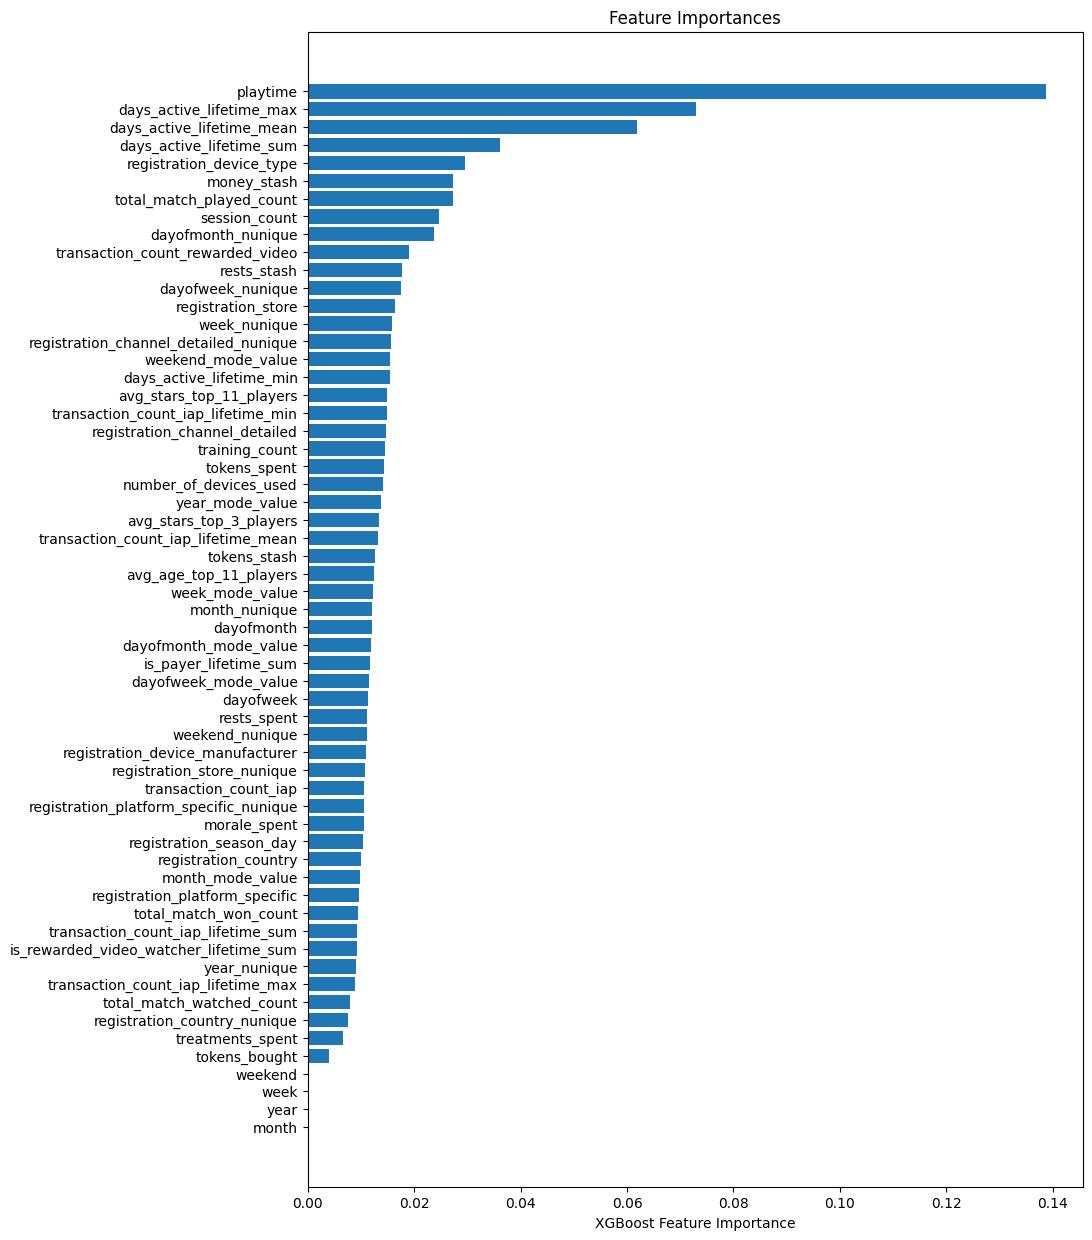

In [6]:
# train a xgboost regressor to select important features
import xgboost as xgb

features = [
 f for f in df_merged_data_train.columns if f not in ("kfold", "days_active_first_28_days_after_registration")
 ]
model = xgb.XGBRegressor(
        n_jobs=-1,
        objective='reg:tweedie',
        # tweedie_variance_power=1.5,
        # tweedie_link='log'
    )
model.fit(df_merged_data_train[features], df_merged_data_train['days_active_first_28_days_after_registration'])
importances = model.feature_importances_
plt.figure(figsize=(10, 15))
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [features[i] for i in idxs])
plt.xlabel('XGBoost Feature Importance')
plt.show()

In [7]:
pd.Series(importances, index=features).sort_values(ascending=False).head(20)
top_20_features = pd.Series(importances, index=features).sort_values(ascending=False).head(20).index
top_30_features = pd.Series(importances, index=features).sort_values(ascending=False).head(30).index
top_40_features = pd.Series(importances, index=features).sort_values(ascending=False).head(40).index
top_50_features = pd.Series(importances, index=features).sort_values(ascending=False).head(50).index

In [9]:
# select from the model
# select from the model
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(estimator=model)
X_transformed = sfm.fit_transform(df_merged_data_train[features], df_merged_data_train['days_active_first_28_days_after_registration'])
support = sfm.get_support()
# get feature names
print([
 x for x, y in zip(features, support) if y == True
])

['registration_device_type', 'session_count', 'playtime', 'total_match_played_count', 'transaction_count_rewarded_video', 'rests_stash', 'money_stash', 'dayofweek_nunique', 'dayofmonth_nunique', 'days_active_lifetime_sum', 'days_active_lifetime_mean', 'days_active_lifetime_max']


In [10]:
supported_features = [x for x, y in zip(features, support) if y == True]
supported_features


['registration_device_type',
 'session_count',
 'playtime',
 'total_match_played_count',
 'transaction_count_rewarded_video',
 'rests_stash',
 'money_stash',
 'dayofweek_nunique',
 'dayofmonth_nunique',
 'days_active_lifetime_sum',
 'days_active_lifetime_mean',
 'days_active_lifetime_max']

In [25]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

df_merged_data_train = pd.read_csv('../cleaned_data/aggregated_data_training.csv', index_col=0)

features_selected = [
 f for f in top_50_features if f not in ("days_active_first_28_days_after_registration")
 ]
# Split data into training and validation sets
X = df_merged_data_train[features_selected].values
y = df_merged_data_train.days_active_first_28_days_after_registration.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Stage 1: Binary classification model for zero vs. non-zero days
y_train_binary = (y_train > 0).astype(int)
y_valid_binary = (y_valid > 0).astype(int)

# Train the binary classifier
clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=6)
clf.fit(X_train, y_train_binary)
p_active = clf.predict_proba(X_valid)[:, 1]  # Probability of being active

# Stage 2: Count regression model for non-zero days
non_zero_mask = y_train > 0
reg = xgb.XGBRegressor(objective='reg:tweedie')
reg.fit(X_train[non_zero_mask], y_train[non_zero_mask])

# Predict the number of active days for non-zero users
days_active_pred = reg.predict(X_valid)

# Combine the predictions
final_prediction = p_active * days_active_pred
preds_clipped = final_prediction.copy()
preds_clipped[preds_clipped > 28] = 28

# Evaluate with MAE
mae = mean_absolute_error(y_valid, final_prediction.astype(int))
mae_clipped = mean_absolute_error(y_valid, preds_clipped.astype(int))
print(f"MAE: {mae}, MAE_clipped: {mae_clipped}")


MAE: 5.5877, MAE_clipped: 5.5828


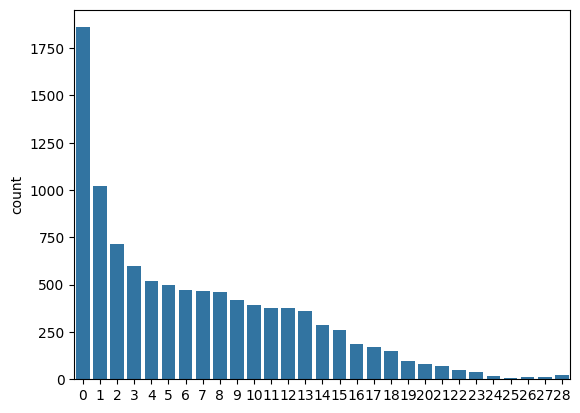

In [26]:
sns.countplot(x=preds_clipped.astype(int))
plt.title("Predicted number of active days")
plt.show()


In [62]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

df_merged_data_train = pd.read_csv('../cleaned_data/aggregated_data_training.csv', index_col=0)

features_selected = [
 f for f in top_50_features if f not in ("days_active_first_28_days_after_registration")
 ]
# Split data into training and validation sets
X = df_merged_data_train[features_selected].values
y = df_merged_data_train.days_active_first_28_days_after_registration.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Stage 1: Binary classification model for zero vs. non-zero days
y_train_binary = (y_train > 0).astype(int)
y_valid_binary = (y_valid > 0).astype(int)

# Train the binary classifier
clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=6)
clf.fit(X_train, y_train_binary)
p_active = clf.predict_proba(X_valid)[:, 1]  # Probability of being active

# Stage 2: Count regression model for non-zero days
non_zero_mask = y_train > 0
reg = xgb.XGBRegressor(objective='reg:absoluteerror')
reg.fit(X_train[non_zero_mask], y_train[non_zero_mask])

# Predict the number of active days for non-zero users
days_active_pred = reg.predict(X_valid)

# Combine the predictions
final_prediction = p_active * days_active_pred
preds_clipped = final_prediction.copy()
preds_clipped[preds_clipped > 28] = 28
preds_clipped[preds_clipped < 0] = 0

# Evaluate with MAE
mae = mean_absolute_error(y_valid, final_prediction.astype(int))
mae_clipped = mean_absolute_error(y_valid, preds_clipped.astype(int))
print(f"MAE: {mae}, MAE_clipped: {mae_clipped}")


MAE: 5.4168, MAE_clipped: 5.4142


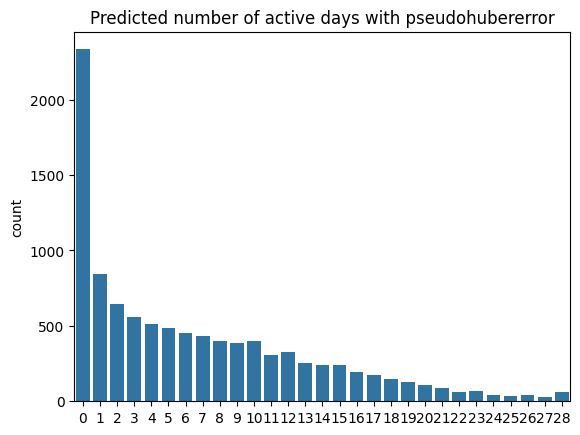

In [61]:
sns.countplot(x=preds_clipped.astype(int))
plt.title("Predicted number of active days with reg:absoluteerror")
plt.show()

In [63]:
# training Xgboost with selected features
from sklearn import metrics

df = pd.read_csv("../folds/train_folds_agg_data_5folds.csv")

# training
features_selected = [
 f for f in top_50_features if f not in ("kfold", "days_active_first_28_days_after_registration")
 ]
 # get training data using folds

print(f"Training with Mean Absolute Error objective - regression")
for fold_ in range(5):
    df_train = df[df.kfold != fold_].reset_index(drop=True)
    # get validation data using folds
    df_valid = df[df.kfold == fold_].reset_index(drop=True)
    # get training data
    x_train = df_train[features_selected].values
    y_train = df_train.days_active_first_28_days_after_registration.values
    # get validation data
    x_valid = df_valid[features_selected].values
    y_valid = df_valid.days_active_first_28_days_after_registration.values
    # initialize xgboost model
    model = xgb.XGBRegressor(
        objective='reg:absoluteerror',
        # tweedie_variance_power=1.5,
        # tweedie_link='log'
    )
    # fit model on training data (ohe)
    model.fit(x_train, y_train)
    # predict on validation data
    # we need the probability values as we are calculating AUC
    # we will use the probability of 1s
    valid_preds = model.predict(x_valid)#[:, 1]
    # get roc auc scores
    # auc = metrics.roc_auc_score(df_valid.days_active_first_28_days_after_registration.values, valid_preds, multi_class='ovr')
    mae = metrics.mean_absolute_error(y_valid, valid_preds)
    mae_int = metrics.mean_absolute_error(y_valid, valid_preds.astype(int))
    preds_clipped = valid_preds.copy()
    preds_clipped[preds_clipped > 28] = 28
    preds_clipped[preds_clipped < 0] = 0
    # print auc
    print(f"Fold = {fold_}, MAE = {mae}, MAE_int = {mae_int}, MAE_clipped = {metrics.mean_absolute_error(y_valid, preds_clipped.astype(int))}")

Training with Mean Absolute Error objective - regression
Fold = 0, MAE = 5.311108846504238, MAE_int = 5.2931, MAE_clipped = 5.2884
Fold = 1, MAE = 5.36609113968499, MAE_int = 5.3533, MAE_clipped = 5.3484
Fold = 2, MAE = 5.313673978502461, MAE_int = 5.2904, MAE_clipped = 5.2828
Fold = 3, MAE = 5.3405525183159455, MAE_int = 5.3254, MAE_clipped = 5.3215
Fold = 4, MAE = 5.351792219235713, MAE_int = 5.3291, MAE_clipped = 5.3251


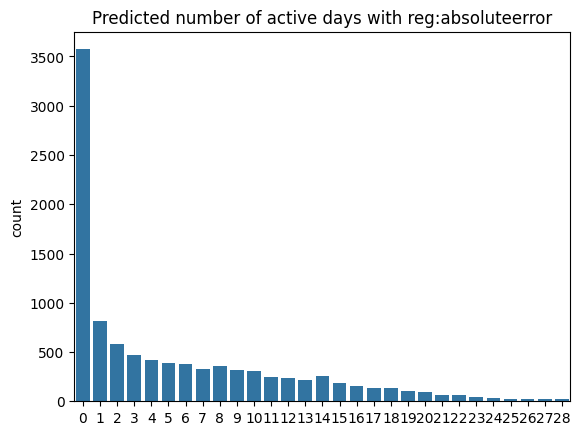

In [64]:
sns.countplot(x=preds_clipped.astype(int))
plt.title("Predicted number of active days with reg:absoluteerror")
plt.show()

In [70]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
import numpy as np

mean_age_top_11_players_train = df_merged_data_train['avg_age_top_11_players'].mean()
df_merged_data_train['avg_age_top_11_players'].fillna(mean_age_top_11_players_train, inplace=True)

features_selected = [
 f for f in top_50_features if f not in ("days_active_first_28_days_after_registration")
 ]
# Split data into training and validation sets
X = df_merged_data_train[features_selected].values
y = df_merged_data_train.days_active_first_28_days_after_registration.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Stage 1: Binary classification for active/inactive
y_train_binary = (y_train > 0).astype(int)
clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=6)
clf.fit(X_train, y_train_binary)
p_active = clf.predict_proba(X_valid)[:, 1]

# Stage 2: Handle non-zero cases
# Create masks for non-zero cases
non_zero_mask = y_train > 0
X_train_non_zero = X_train[non_zero_mask]
y_train_non_zero = y_train[non_zero_mask]

# Create masks for low/high activity
low_activity_mask = (y_train_non_zero > 0) & (y_train_non_zero <= 15)
high_activity_mask = (y_train_non_zero >= 16)

# Train gating model
gating_model = LogisticRegression()
y_train_binary = np.where(low_activity_mask, 0, 1)
gating_model.fit(X_train_non_zero, y_train_binary)

# Train separate models for low/high activity
low_activity_model = xgb.XGBRegressor(objective='reg:absoluteerror')
high_activity_model = xgb.XGBRegressor(objective='reg:absoluteerror')

low_activity_model.fit(X_train_non_zero[low_activity_mask], y_train_non_zero[low_activity_mask])
high_activity_model.fit(X_train_non_zero[high_activity_mask], y_train_non_zero[high_activity_mask])

# Make predictions on validation set
# First, create mask for active users in validation set
valid_active_mask = p_active > 0.5
X_valid_active = X_valid[valid_active_mask]
y_valid_active = y_valid[valid_active_mask]

# Get predictions for active users
gating_probs = gating_model.predict_proba(X_valid_active)[:, 1]
low_preds = low_activity_model.predict(X_valid_active)
high_preds = high_activity_model.predict(X_valid_active)

# Initialize final predictions array with zeros
final_predictions = np.zeros(len(y_valid))
high_activity_mask = gating_probs > 0.5
active_high = valid_active_mask.copy()
active_high[valid_active_mask] = high_activity_mask

active_low = valid_active_mask.copy()
active_low[valid_active_mask] = ~high_activity_mask

# Use high predictions where gating_probs > 0.5, low predictions otherwise
final_predictions[active_high] = high_preds[high_activity_mask]
final_predictions[active_low] = low_preds[~high_activity_mask]

# Clip predictions to valid range
final_predictions[final_predictions > 28] = 28
final_predictions[final_predictions < 0] = 0

# Calculate metrics
mae = mean_absolute_error(y_valid, final_predictions)
mae_int = mean_absolute_error(y_valid, final_predictions.astype(int))
print(f"MAE: {mae}, MAE_int: {mae_int}")

/tmp/ipykernel_28765/1791723163.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged_data_train['avg_age_top_11_players'].fillna(mean_age_top_11_players_train, inplace=True)


MAE: 5.799268681246042, MAE_int: 5.8207


In [11]:
mean_age_top_11_players_train = df_merged_data_train['avg_age_top_11_players'].mean()
df_merged_data_train['avg_age_top_11_players'].fillna(mean_age_top_11_players_train, inplace=True)

top_50_features = pd.read_csv('../top_50_features.csv', index_col=0)

features_selected = [
 f for f in top_50_features if f not in ("days_active_first_28_days_after_registration")
 ]

df_merged_data_train = df_merged_data_train[df_merged_data_train.days_active_first_28_days_after_registration > 0]
# Split data into training and validation sets
X = df_merged_data_train[features_selected].values
y = df_merged_data_train.days_active_first_28_days_after_registration.values


/tmp/ipykernel_3101/1340496482.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged_data_train['avg_age_top_11_players'].fillna(mean_age_top_11_players_train, inplace=True)


In [16]:
# mean of y
y.mean()
# median of y
np.percentile(y, 50)

np.float64(8.0)

In [14]:
# mae between y and y_mean
import sklearn.metrics as metrics
metrics.mean_absolute_error(y, np.full_like(y, y.mean()))

np.float64(8.799255590759483)

In [17]:
metrics.mean_absolute_error(y, np.full_like(y, np.percentile(y, 50)))


np.float64(8.531606632009597)

comment: this is baseline prediction if we use a naive approach of predicting the mean/median number of days active

In [41]:
df1 = pd.read_csv('../aggregated_data/merged_data_training.csv', index_col=0)
df1.head()

,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,playtime,number_of_devices_used,total_match_played_count,total_match_won_count,total_match_watched_count,transaction_count_iap,transaction_count_rewarded_video,tokens_spent,tokens_stash,tokens_bought,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration,year,week,month,dayofweek,dayofmonth,weekend,year_nunique,year_mode_value,month_nunique,month_mode_value,week_nunique,week_mode_value,dayofweek_nunique,dayofweek_mode_value,dayofmonth_nunique,dayofmonth_mode_value,weekend_nunique,weekend_mode_value,registration_country_nunique,registration_channel_detailed_nunique,registration_store_nunique,registration_platform_specific_nunique,is_payer_lifetime_sum,is_rewarded_video_watcher_lifetime_sum,days_active_lifetime_sum,days_active_lifetime_mean,days_active_lifetime_max,days_active_lifetime_min,days_active_lifetime_std,transaction_count_iap_lifetime_sum,transaction_count_iap_lifetime_mean,transaction_count_iap_lifetime_max,transaction_count_iap_lifetime_min,transaction_count_iap_lifetime_std,recency_days,age_days,frequency,match_win_rate,avg_tokens_spent_per_session,inactive_days,registration_frequency_days
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,5,19,0,7,0,1,0,1,141062,1,2,1,0,0,0,0,114,0,524,0,0,0,1066076772,4.721867,5.451511,22.0,0,0,2024,21,5,5,25,1,2,2022,2,4,2,16,2,3,2,7,2,0,1,2,1,1,0,1,19,9.5,18,1,12.020815,0,0.0,0,0,0.0,384,765,9.5,0.500000,0.00,746,382.5
7,0,55,3,27,2,1,5,1,521754,1,0,0,0,0,0,0,157,0,962,0,0,0,1224446429,4.911067,5.303822,22.0,1,0,2024,24,6,4,14,0,2,2023,3,2,3,6,3,0,2,6,2,0,1,2,2,2,0,1,24,8.0,21,1,11.269428,0,0.0,0,0,0.0,383,800,12.0,0.000000,0.00,776,400.0
13,0,39,3,13,0,1,5,2,1703183,1,0,0,0,0,0,20,232,0,829,0,0,0,1221792142,5.018146,5.746889,24.0,3,0,2024,22,5,4,31,0,2,2022,2,8,2,33,2,1,2,17,1,0,1,1,1,1,0,1,222,111.0,221,1,155.563492,0,0.0,0,0,0.0,288,591,111.0,0.000000,10.00,369,295.5
23,0,24,3,13,1,1,3,4,3181700,1,3,2,1,0,0,79,8,0,180,39,12,9,928112709,5.827455,6.692578,22.0,7,1,2024,22,5,4,31,0,1,2023,1,8,1,35,1,2,1,30,1,0,1,1,1,1,0,1,2,2.0,2,2,0.000000,0,0.0,0,0,0.0,275,275,2.0,0.666667,19.75,273,275.0
25,5,17,0,28,0,1,0,5,5866921,1,1,0,1,0,0,77,70,0,209,80,0,2,326553498,5.340412,5.775289,24.0,6,3,2024,24,6,5,15,1,2,2022,1,8,2,33,2,1,2,15,1,0,1,2,1,1,0,1,19,9.5,18,1,12.020815,0,0.0,0,0,0.0,305,661,9.5,0.000000,15.40,642,330.5


In [42]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 5 to 218956
Data columns (total 69 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   registration_platform_specific                50000 non-null  int64  
 1   registration_country                          50000 non-null  int64  
 2   registration_store                            50000 non-null  int64  
 3   registration_season_day                       50000 non-null  int64  
 4   registration_channel_detailed                 50000 non-null  int64  
 5   registration_device_type                      50000 non-null  int64  
 6   registration_device_manufacturer              50000 non-null  int64  
 7   session_count                                 50000 non-null  int64  
 8   playtime                                      50000 non-null  int64  
 9   number_of_devices_used                        50000 non-null  int

In [43]:
df1.shape

(50000, 69)

In [44]:
df2 = pd.read_csv('../aggregated_data/aggregated_previous_lives_training_data.csv', index_col=0)
df2.head()

,year_nunique,year_mode_value,month_nunique,month_mode_value,week_nunique,week_mode_value,dayofweek_nunique,dayofweek_mode_value,dayofmonth_nunique,dayofmonth_mode_value,weekend_nunique,weekend_mode_value,first_registration_date_prev_lives,last_registration_date_prev_lives,registration_country_nunique,registration_channel_detailed_nunique,registration_store_nunique,registration_platform_specific_nunique,is_payer_lifetime_sum,is_rewarded_video_watcher_lifetime_sum,days_active_lifetime_sum,days_active_lifetime_mean,days_active_lifetime_max,days_active_lifetime_min,days_active_lifetime_std,transaction_count_iap_lifetime_sum,transaction_count_iap_lifetime_mean,transaction_count_iap_lifetime_max,transaction_count_iap_lifetime_min,transaction_count_iap_lifetime_std
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2,2022,2,4,2,16,2,3,2,7,2,0,2022-04-21,2023-05-07,1,2,1,1,0,1,19,9.5,18,1,12.020815,0,0.0,0,0,0.0
7,2,2023,3,2,3,6,3,0,2,6,2,0,2022-04-06,2023-05-28,1,2,2,2,0,1,24,8.0,21,1,11.269428,0,0.0,0,0,0.0
13,2,2022,2,8,2,33,2,1,2,17,1,0,2022-10-18,2023-08-17,1,1,1,1,0,1,222,111.0,221,1,155.563492,0,0.0,0,0,0.0
23,1,2023,1,8,1,35,1,2,1,30,1,0,2023-08-30,2023-08-30,1,1,1,1,0,1,2,2.0,2,2,NaN,0,0.0,0,0,NaN
25,2,2022,1,8,2,33,2,1,2,15,1,0,2022-08-24,2023-08-15,1,2,1,1,0,1,19,9.5,18,1,12.020815,0,0.0,0,0,0.0


In [46]:
df3 = pd.read_csv('/root/projects/ds_chlg/Data Science Challenge/Data Science/folds/train_folds_merged_5folds.csv', index_col=0)
df3.kfold.value_counts(normalize=True)

kfold
0    0.2
1    0.2
2    0.2
3    0.2
4    0.2
Name: proportion, dtype: float64

In [47]:
df3.shape

(50000, 70)

=== Best Parameters ===
Parameters: {'objective': 'reg:absoluteerror', 'eta': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0, 'reg_lambda': 10.0, 'min_child_weight': 1}
Valid MAE: 5.2716

In [54]:
import sys
import os
current_dir = os.getcwd() 
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(project_root)
from src.train import cross_validate_model, round_and_clip
from sklearn import metrics
import xgboost as xgb

df = pd.read_csv("/root/projects/ds_chlg/Data Science Challenge/Data Science/folds/train_folds_merged_5folds.csv")
features = [f for f in df.columns if f not in ("kfold", "days_active_first_28_days_after_registration")]

In [55]:
# Trying parameters: {'objective': 'reg:absoluteerror', 'eta': 0.025, 'gamma': 0.5, 'max_depth': 9, 'reg_lambda': 0.5, 'min_child_weight': 1}
model = xgb.XGBRegressor(objective='reg:absoluteerror', eta=0.025, gamma=0.5, max_depth=9, reg_lambda=2, min_child_weight=1)
results = cross_validate_model(df, features, model=model, prediction_transformer=round_and_clip)
results

Fold 0, Train MAE = 4.5829, Valid MAE = 5.4002
Fold 1, Train MAE = 4.6078, Valid MAE = 5.3132
Fold 2, Train MAE = 4.6006, Valid MAE = 5.3796
Fold 3, Train MAE = 4.6098, Valid MAE = 5.2863
Fold 4, Train MAE = 4.5766, Valid MAE = 5.4262

Mean scores:
train_mae: 4.5955 ± 0.0134
valid_mae: 5.3611 ± 0.0529


{'train_mae': [np.float64(4.582875),
  np.float64(4.60775),
  np.float64(4.6006),
  np.float64(4.609775),
  np.float64(4.576575)],
 'valid_mae': [np.float64(5.4002),
  np.float64(5.3132),
  np.float64(5.3796),
  np.float64(5.2863),
  np.float64(5.4262)]}

In [56]:
model = xgb.XGBRegressor(objective='reg:absoluteerror')
results = cross_validate_model(df, features, model=model, prediction_transformer=round_and_clip)
results

Fold 0, Train MAE = 4.7627, Valid MAE = 5.3812
Fold 1, Train MAE = 4.8024, Valid MAE = 5.2847
Fold 2, Train MAE = 4.8342, Valid MAE = 5.3418
Fold 3, Train MAE = 4.8725, Valid MAE = 5.2580
Fold 4, Train MAE = 4.8942, Valid MAE = 5.3741

Mean scores:
train_mae: 4.8332 ± 0.0473
valid_mae: 5.3280 ± 0.0488


{'train_mae': [np.float64(4.762725),
  np.float64(4.802425),
  np.float64(4.83425),
  np.float64(4.8725),
  np.float64(4.894175)],
 'valid_mae': [np.float64(5.3812),
  np.float64(5.2847),
  np.float64(5.3418),
  np.float64(5.258),
  np.float64(5.3741)]}

In [79]:
# Trying parameters: {'objective': 'reg:absoluteerror', 'eta': 0.08, 'gamma': 0.5, 'max_depth': 6, 'reg_lambda': 0.01, 'min_child_weight': 3}
model = xgb.XGBRegressor(objective='reg:absoluteerror', eta=0.08, gamma=0.5, max_depth=6, reg_lambda=0.01, min_child_weight=3)
results = cross_validate_model(df, features, model=model, prediction_transformer=round_and_clip)
results

Fold 0, Train MAE = 4.9807, Valid MAE = 5.3287
Fold 1, Train MAE = 5.0506, Valid MAE = 5.2202
Fold 2, Train MAE = 5.0371, Valid MAE = 5.3011
Fold 3, Train MAE = 5.0390, Valid MAE = 5.2062
Fold 4, Train MAE = 5.0135, Valid MAE = 5.3308

Mean scores:
train_mae: 5.0242 ± 0.0249
valid_mae: 5.2774 ± 0.0536


{'train_mae': [np.float64(4.980675),
  np.float64(5.0506),
  np.float64(5.03715),
  np.float64(5.038975),
  np.float64(5.013475)],
 'valid_mae': [np.float64(5.3287),
  np.float64(5.2202),
  np.float64(5.3011),
  np.float64(5.2062),
  np.float64(5.3308)]}

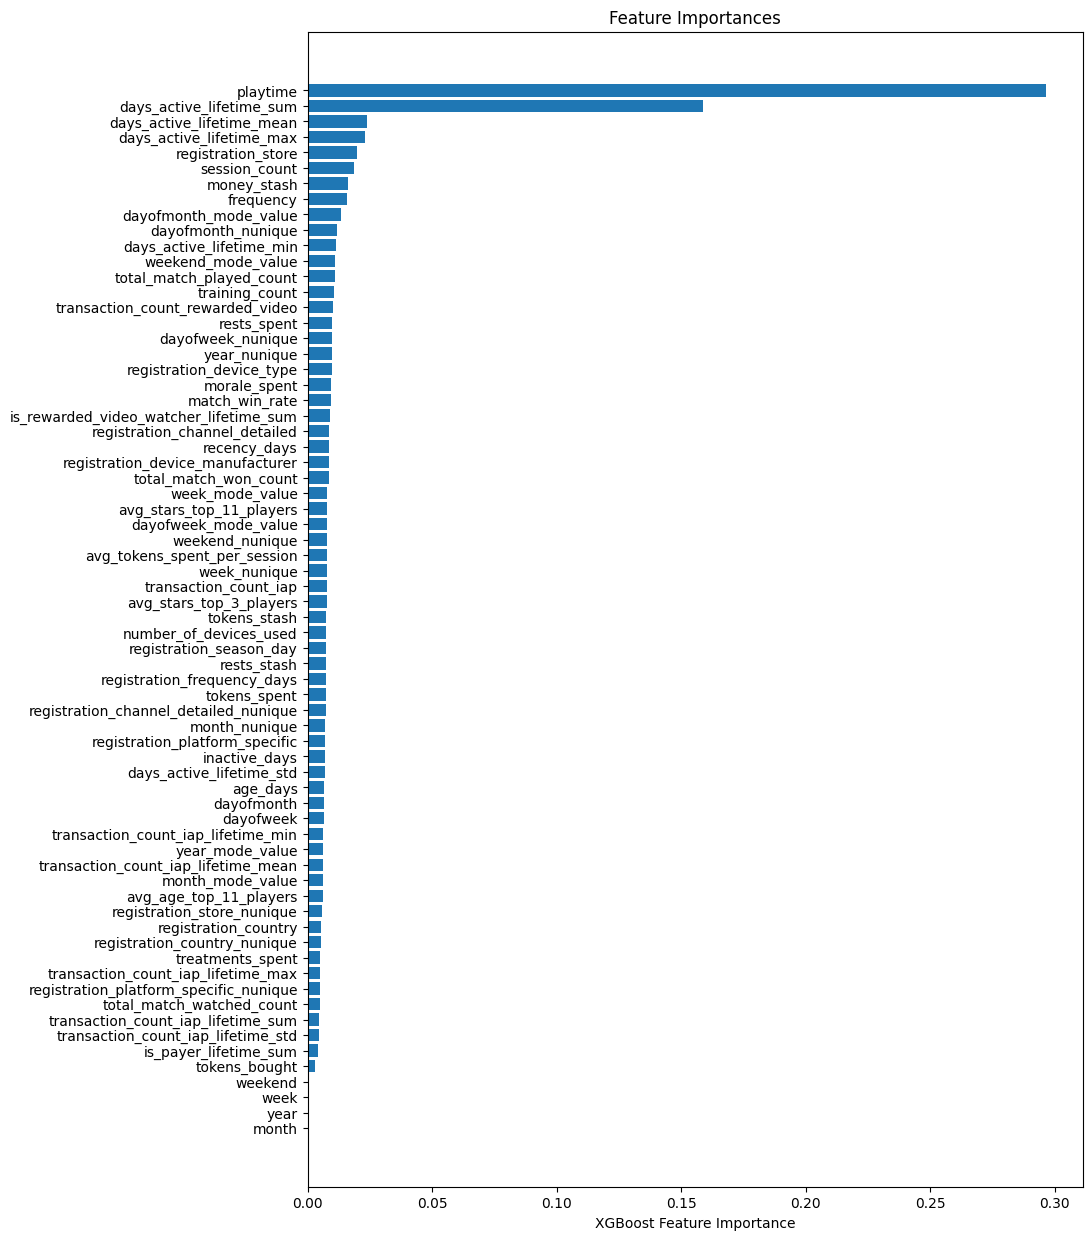

In [80]:
# select important features
import xgboost as xgb
df_merged_data_train = pd.read_csv('/root/projects/ds_chlg/Data Science Challenge/Data Science/aggregated_data/merged_data_training.csv', index_col=0)
features = [
 f for f in df_merged_data_train.columns if f not in ("kfold", "days_active_first_28_days_after_registration")
 ]
model = xgb.XGBRegressor(
        n_jobs=-1,
        objective='reg:absoluteerror'
    )
model.fit(df_merged_data_train[features], df_merged_data_train['days_active_first_28_days_after_registration'])
importances = model.feature_importances_
plt.figure(figsize=(10, 15))
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [features[i] for i in idxs])
plt.xlabel('XGBoost Feature Importance')
plt.show()

In [96]:
df_merged_data_train = pd.read_csv('/root/projects/ds_chlg/Data Science Challenge/Data Science/aggregated_data/merged_data_training.csv', index_col=0)

features = [
 f for f in df_merged_data_train.columns if f not in ("kfold", "days_active_first_28_days_after_registration")
]
top_50_features = pd.Series(importances, index=features).sort_values(ascending=False).head(50).index

df = pd.read_csv("/root/projects/ds_chlg/Data Science Challenge/Data Science/folds/train_folds_merged_5folds.csv")
features = [f for f in top_50_features if f not in ("kfold", "days_active_first_28_days_after_registration")]
model = xgb.XGBRegressor(objective='reg:absoluteerror', eta=0.08, gamma=0.5, max_depth=6, reg_lambda=0.01, min_child_weight=3)
results = cross_validate_model(df, features, model=model, prediction_transformer=round_and_clip)
results

Fold 0, Train MAE = 5.0071, Valid MAE = 5.3414
Fold 1, Train MAE = 5.0594, Valid MAE = 5.2344
Fold 2, Train MAE = 5.0471, Valid MAE = 5.2939
Fold 3, Train MAE = 5.0327, Valid MAE = 5.2085
Fold 4, Train MAE = 5.0345, Valid MAE = 5.3469

Mean scores:
train_mae: 5.0361 ± 0.0174
valid_mae: 5.2850 ± 0.0557


{'train_mae': [np.float64(5.0071),
  np.float64(5.05935),
  np.float64(5.047075),
  np.float64(5.032675),
  np.float64(5.034525)],
 'valid_mae': [np.float64(5.3414),
  np.float64(5.2344),
  np.float64(5.2939),
  np.float64(5.2085),
  np.float64(5.3469)]}

In [77]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

df_merged_data_train = pd.read_csv('../cleaned_data/aggregated_data_training.csv', index_col=0)
top_50_features = pd.read_csv('../top_50_features.csv', index_col=0).index

features_selected = [
 f for f in top_50_features if f not in ("days_active_first_28_days_after_registration")
 ]
# Split data into training and validation sets
X = df_merged_data_train[features_selected].values
y = df_merged_data_train.days_active_first_28_days_after_registration.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Stage 1: Binary classification model for zero vs. non-zero days
y_train_binary = (y_train > 0).astype(int)
y_valid_binary = (y_valid > 0).astype(int)

# Train the binary classifier
clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=6)
clf.fit(X_train, y_train_binary)
p_active = clf.predict_proba(X_valid)[:, 1]  # Probability of being active

# Stage 2: Count regression model for non-zero days
non_zero_mask = y_train > 0
reg = xgb.XGBRegressor(objective = 'reg:absoluteerror', eta = 0.1, max_depth = 6, n_estimators = 100, subsample = 1.0, reg_lambda = 10.0, min_child_weight = 1)
reg.fit(X_train[non_zero_mask], y_train[non_zero_mask])

# Predict the number of active days for non-zero users
days_active_pred = reg.predict(X_valid)

# Combine the predictions
final_prediction = p_active * days_active_pred
transformed_preds = round_and_clip(final_prediction)

# Evaluate with MAE
mae = mean_absolute_error(y_valid, final_prediction)
mae_clipped = mean_absolute_error(y_valid, transformed_preds)
mae_train = mean_absolute_error(y_train, (y_train))
mae_train_clipped = mean_absolute_error(y_train, round_and_clip(y_train))
print(f"MAE: {mae}, MAE_clipped: {mae_clipped}, MAE_train: {mae_train}, MAE_train_clipped: {mae_train_clipped}")


MAE: 5.4554708357824016, MAE_clipped: 5.4362, MAE_train: 0.0, MAE_train_clipped: 0.0


In [78]:
p_active

array([0.25277364, 0.28166655, 0.97305423, ..., 0.9992849 , 0.5124702 ,
       0.8483915 ], dtype=float32)

In [82]:
pd.Series(importances, index=features).sort_values(ascending=False).head(20).index



Index(['playtime', 'days_active_lifetime_sum', 'days_active_lifetime_mean',
       'days_active_lifetime_max', 'registration_store', 'session_count',
       'money_stash', 'frequency', 'dayofmonth_mode_value',
       'dayofmonth_nunique', 'days_active_lifetime_min', 'weekend_mode_value',
       'total_match_played_count', 'training_count',
       'transaction_count_rewarded_video', 'rests_spent', 'dayofweek_nunique',
       'year_nunique', 'registration_device_type', 'morale_spent'],
      dtype='object')

In [87]:
importances.shape

(68,)